# Home Credit Defalut Risk
참고1 : https://github.com/Aete/Kaggle-Kernels-translations-korean/blob/master/Introduction%20Manual%20Feature%20Engineering%20(%ED%95%9C%EA%B8%80%20%EB%B2%88%EC%97%AD%EB%B3%B8).ipynb <br>
참고2 : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

## Introduction : Manual Feature Engineering

#### data info
* application_train/application_test : home credit의 각 대출 application 정보가 있다. 
    * SK_ID_CURR : 이 값으로 식별됨
    * TARGET : 0 = 대출 상환, 1 = 대출 미상환
* bureau : 다른 재정 기관에서 클라이언트의 이전 신용 데이터. application 데이터에 있는 하나의 대출은 다수의 이전 신용도가 있다. 
* bureau_balance : bureau의 월간 데이터. 각 행은 한달을 말함.
* previous_application : application data에 대출이 있는 고객의 previous application for loan. 여러 개의 이전 대출값이 있을 수 있다.
* POS_CASH_BALANCE : 고객의 point of sale, 현금 대출에 대한 월별 데이터
* credit_card_balance : 각 행은 신용카드의 잔액 한달 데이터를 뜻함.
* installments_payment : 이전 대출에서 payment 히스토리



--------------------------------------------------------------------------------------------------------------------------------------------
## What I learned
* 커널밀도추정그래프 (kde plot) 시각화 함수 생성
* 수치 데이터의 대표값 계산 with agg 함수 (count,min,max,sum)
    * levels 
    * groupby 로 두개의 집계값을 묶고 싶을 때
        * groupby(' ').agg(['sum','mean']) 
    * merge
* 상관계수 분석 (corr)
    * sorted( , key=lambda x)
* 대표값 계산 & 상관계수 분석을 위한 각각의 함수 생성
* 범주형 데이터 one-hot encoding
* 오브젝트(object) 제거 
    * gc.enable()
* 누락된 값 개수와, 누락된 값 개수의 비중 확인하는 concat table 보여주는 함수생성
* 딕셔너리 형태에서 key와 value를 한꺼번에 for문 반복하려면 items() 사용.

In [31]:
# 데이터 처리을 위한 Pandas 및 Numpy
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np


# 시각화를 위한 matplotlib 및 seaborn
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


# pandas에서 나오는 경고문 무시
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [3]:
# bureau 파일 읽기 
# Read in bureau
bureau = pd.read_csv('./Home credit default risk/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [14]:
# 고객 id (SK_ID_CURR)를 기준으로 groupby 실행, 이전 대출 갯수를 파악하고, Column 이름을 변경
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts=bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU':'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [7]:
# 훈련용 데이터프레임과 병합(Join)
# Join to the training dataframe

train = pd.read_csv('./Home credit default risk/application_train.csv')
train = train.merge(previous_loan_counts, on='SK_ID_CURR', how = 'left')

# NaN 값에 0을 대입
# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## R value 를 활용한 변수 유용성 평가 (Assessing Usefulness of New Variable with r value)
* 커널밀도추정그래프 (Kernel Density Estimate Plots)

In [35]:
def kde_target(var_name, df):
    # 새로 생성된 변수와 TARGET간의 상관계수 계산
    corr = df['TARGET'].corr(df[var_name])
    
    #대출을 상환한 그룹과 그렇지 않은 그룹의 중간값(median) 계산
    avg_repaid = df.ix[df['TARGET']==0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET']==1, var_name].median()
    
    plt.figure(figsize=(12,6))
    
    # target값에 따라 색을 다르게해서 그래프 작성
    sns.kdeplot(df.ix[df['TARGET']==0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET']==1, var_name], label='TARGET == 1')
    
    #그래프 라벨링
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # 상관계수 출력
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid = %0.4f' % avg_repaid)

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid = 0.5460


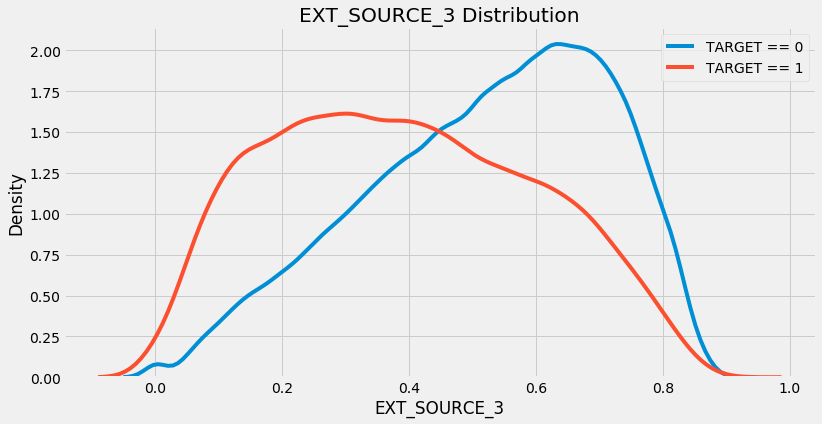

In [36]:
kde_target('EXT_SOURCE_3', train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid = 4.0000


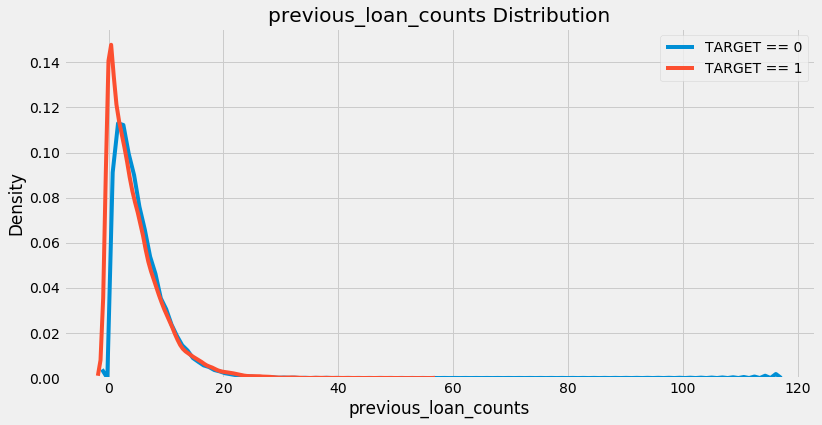

In [37]:
kde_target('previous_loan_counts', train)

* 이를 통해 새로 생성된 변수 previous_loan_counts 가 중요하지 않음을 알 수 있다. 상관계수가 너무 작고, TARGET값에 따른 분포의 차이도 거의 없다.

## 수치 데이터의 대표값들을 계산 (Aggregating Numeric Columns)
* agg를 활용하여 데이터프레임의 평균, 최대값, 최소값, 합계 등을 계산
* bureau 데이터 프레임 안의 수치 데이터를 활용하기위해
    * 고객 ID별로 그룹화(groupby)를 수행하고, 그룹화된 데이터프레임의 대표값들을 agg를 통해 구한 뒤, 결과를 훈련 데이터셋과 병합.

In [41]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [67]:
# 고객 id에 따라 데이터프레임을 그룹화하고, 대표값들을 계산
bureau_agg = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR',as_index=False).agg(['count','mean','max','min','sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

생성된 Column 의 컬럼명을 변경. count, mean, max, min, sum 별로 컬럼 생성. <br>
여기서는 Multi-Level index 데이터프레임을 작업의 대상으로 합니다. 이러한 부분은 혼동을 줄 수 있고, 작업하기도 어렵기 때문에, single-level index로 최대한 빠르게 변환하고자 하였습니다.

In [68]:
bureau_agg.columns.levels[0]

Index(['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY',
       'SK_ID_CURR'],
      dtype='object')

In [69]:
bureau_agg.columns.levels[1][:-1]

Index(['count', 'mean', 'max', 'min', 'sum'], dtype='object')

In [72]:
# Column 리스트 생성
columns = ['SK_ID_CURR']    # ID컬럼명은 냅두고 다른 컬럼들만 바꾸기 위함

# 변수(원본 데이터프레임의 column name)에 따라 반복문을 실행
for var in bureau_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':   # id column은 생략
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' % (var, stat))

In [73]:
# 생성된 list를 데이터프레임의 column name으로 지정
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [63]:
# 훈련데이터와 병합
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


## 목표값과 대표값들의 상관계수 분석 (Correlations of Aggregated Values with Target)
모델링에 중요한 변수들을 알기위해 새롭게 생성된 값들과 목표값(target)과의 상관계수를 분석한다.

In [77]:
# 새로운 상관계수들에 대한 리스트를 생성
new_corrs = []

# column별로 반복문을 실행
for col in columns:
    # 목표값(target)과의 상관계수를 계산
    corr = train['TARGET'].corr(train[col])
    # 튜플(tuple)로 리스트에 추가
    new_corrs.append((col, corr))

In [83]:
# 상관계수들을 절대값에 따라 정렬
# 큰 값부터 앞에 나오게하기 위해서는 'reverse'를 True로 설정해야 합니다.
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse=True )           # 복잡한 객체를 정렬할 때 sorted의 key값 사용
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998132),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010391),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968697),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920844),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102095),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758624),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997342),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111618),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835924),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073035),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484685),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.041403635353060284),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632938),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616267),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332554)]

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid = -1067.0000


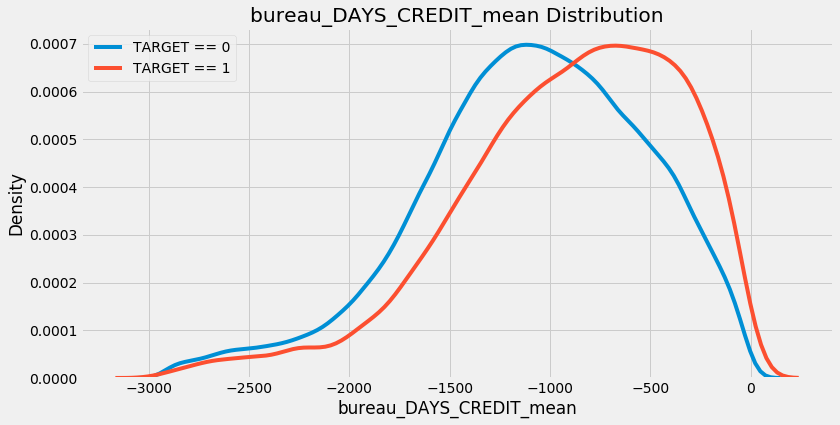

In [88]:
kde_target('bureau_DAYS_CREDIT_mean', train)


이 column은 '고객이 신용관리국 신용등급을 신청한 날로부터 현 대출신청까지 걸린 기간은 몇 일인가? (How many days before current application did client apply for Credit Bureau credit)'에 관한 데이터입니다. 이것을 이전 대출을 받고나서 'Home Credit'에서 대출을 받기전까지 걸린 일수(the number of days)로 해석하려 합니다. 그러므로, 마이너스 수치가 크다는 것은 이전 대출이 이루어진 시점이 더 오래됐음을 의미합니다. 여기서, 이 변수의 평균들과 목표값(target)이 매우 약한 양의 상관관계를 갖는 다는 것은 더 오래된 과거에 대출을 신청했던 고객들은 'Home Credit'에서 대출을 상환할 가능성이 높다는 것을 의미합니다. 그러나 이렇게 약한 상관관계는 그저 노이즈일 가능성도 있습니다.(With a correlation this weak though, it is just as likely to be noise as a signal.)

**다중비교문제 (The Multiple Comparisons Problem)**

변수가 매우 많을 때는, 다중비교문제로 알려진 우연에 의해 변수들이 목표값(target)에 대해 연관성을 가질 것으로 기대할 수 있습니다. 수백개의 특성(Feature)들을 만들 수 있지만, 몇개의 경우, 그저 데이터안의 랜덤하게 있는 노이즈값들에 의해 목표값(target)과 연관성을 가지는 것처럼 보일 수 있습니다. 이러한 변수들은 훈련 데이터상에서는 목표값과 관련성이 있는 것처럼 보이지만, 관련성들이 테스트 데이터까지 일반화될 수 없기 때문에 모델에 있어 오버피팅(과적합, overfit)을 야기할 수 있습니다. 그렇기에 Feature들을 만드는 것은 많은 고려가 필요합니다.

## 수치데이터의 대표값 연산을 위한 함수 생성 (Function for Numeric Aggregations)
이전의 작업들을 요약하여, 수치데이터의 대표값 계산을 위한 함수를 생성하도록 하겠습니다. 이 함수는 데이터프레임 전체에 걸쳐 수치 데이터 column들의 대표값들을 계산하는 역할을 수행합니다. 추후 다른 데이터프레임에 같은 연산을 적용할 경우, 이 함수를 활용하고자 합니다.

In [91]:
def agg_numeric(df, group_var, df_name):
       '''
    데이터프레임안의 수치데이터에 한하여 대표값들을 계산합니다. 이것은 새로운 feature들을 만드는 데 활용될 수 있습니다.
    (Aggregates the numeric values in a dataframe. This can be used to create features for each instance
     of the grouping variable.)
    
    
    파라미터(Parameters)
    -------------------
        df (dataframe): 연산의 대상이되는 데이터프레임 (the dataframe to calculate the statistics on)
        group_var (string): 그룹화(groupby)의 기준이되는 column (the variable by which to group df)
        df_name (string): column명을 재정의하는데 쓰이는 변수 (the variable used to rename the columns)
        
        
    출력값(Returns)
    -------------------
        agg (dataframe): 
            모든 수치데이터 column들의 대표값들이 연산된 데이터프레임. 각각의 그룹화된 인스턴스들은 대표값(평균, 최소값, 최대값, 합계)
            들을 가짐. 또한, 새롭게 생성된 feature들을 구분하기위해 column들의 이름을 재정의    
            
        agg (dataframe):    
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    '''
    
    # 그룹화 대상이 아닌 id들을 제거
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns=col)
    
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    # 특정 변수들을 그룹화하고 대표값들을 계산
    agg = numeric_df.groupby(group_var).agg(['count','mean','max','min','sum']).reset_index()
    
    # 새로운 column 이름들을 생성
    columns = [group_var]
    
    # 변수(원본 데이터프레임의 column name)에 따라 반복문을 실행
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    agg.columns = columns
    return agg

In [92]:
bureau_agg_new = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


* 함수가 제대로 작동하는 지 살펴보기 위해, 수작업으로 만든 데이터프레임과 비교

In [93]:
bureau_agg.head()


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


**상관계수 함수 생성**

계속해서 진행하기 전, 목표값(target)과 변수간 상관계수를 계산하기 위한 코드도 작성하도록 하겠습니다.

In [94]:
# 데이터프레임상의 목표값(target)과의 상관계수를 계산하기 위한 함수
def target_corrs(df):
    corrs =[]
    for col in df.columns:
        print(col)
        
        # target column은 생략
        if col != 'TARGET':
            corr = df['TARGET'].corr(df[col])
            # 튜플(tuple)로 리스트에 추가
            corrs.append((col, corr))
    # 상관계수들을 절대값 크기에 따라 정렬
    corrs = sorted(corrs, key=lambda x: abs(x[1]), reverse=True)
    
    return corrs

## 범주형 데이터(Categorical Values)
* 고객 ID 별로 credit대출인지, cash대출인지, home대출인지를 카운팅
* 그다음, 고객별 대출 횟수를 정규화 (고객별 대출 횟수의 합계를 1로하여 계산)

데이터프레임의 범주형 column들에 한하여 one-hot 인코딩 적용 (dtype==object)

In [122]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR']=bureau['SK_ID_CURR']        # bureau에 있는 'SK_ID_CURR'컬럼을 붙임.
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [130]:
categorical_grouped =categorical.groupby('SK_ID_CURR').agg(['sum','mean']).head()
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

sum는 고객별 해당 범주에 속한 대출의 총 횟수를 말합니다. <br>
그리고 mean은 횟수를 정규화시킨 것입니다. one-hot 인코딩을 통해 이러한 수치들을 계산하는 과정을 매우 편리하게 만들어줍니다. <br>

여기서, 지난번 column 제목들을 재정의할 때 사용하였던 것과 비슷한 함수를 활용하겠습니다. 다시 말하면, multi-level index로 작성되어있는 column들을 다룰 것입니다. <br>
범주형 데이터가 속한 column의 이름을 차용한 First level(level 0)을 따라 반복문을 먼저 실행하고, 그 다음 계산된 통계치들을 따라 반복문을 한번 더 실행할 것입니다.  <br>
level 0의 이름에 통계치의 종류를 합쳐 column 제목들을 재정의할 것입니다. 예를 들면, CREDIT_ACTIVE_Active가 level 0이고, sum이 level 1인 column은 CREDIT_ACTIVE_Active_count로 정의됩니다.

In [137]:
categorical_grouped.columns.levels[0]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan',
       'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
       'CREDIT_TYPE_Loan for the purchase of equipment',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan',
       'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_Real estate loan',
       'CREDIT_TYPE_Unknown type of loan'],
      dtype='object')

In [138]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [139]:
group_var = 'SK_ID_CURR'

# 새로운 column 제목들을 저장하기 위한 리스트를 생성
columns = []

for var in categorical_grouped.columns.levels[0]:
    # 고객 id column은 생략
    if var != 'SK_ID_CURR':
        # for stat in levels[1]로 하면 컬럼명은'sum','mean'으로 
        for stat in ['count','count_norm']:
            columns.append('%s_%s' % (var, stat))

categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


sum column은 총 횟수를 나타내며, count_norm column은 횟수를 정규화시킨 것입니다. 이제 이 데이터프레임을 훈련 데이터셋과 합치겠습니다.

In [141]:
train= train.merge(categorical_grouped, left_on ='SK_ID_CURR', right_index=True, how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
train.shape

(307511, 229)

In [143]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 범주형 데이터들을 처리하기 위한 함수 생성 (Function to Handle Categorical Variables)
코드를 좀 더 효율적으로 만들기 위해, 범주형 데이터들을 처리하기 위한 함수를 만들 것입니다. agg_numeric 함수를 만들 때 했던 것과 같은 방식으로 데이터 프레임을 그룹화할 것입니다. 그 다음 각각의 범주에 따라 counts와 normalized counts를 계산할 것입니다.

In [144]:
def count_categorical(df, group_var, df_name):
    
    # 범주형 column들을 선택
    categorical = pd.get_dummies(df.select_dtypes('object'))
    
    # 확실히 id가 column에 있도록 지정 
    categorical[group_var] = df[group_var]
    
    # group_var를 기준으로 그룹화하고 sum과 mean을 계산
    categorical = categorical.groupby(group_var).agg(['sum','mean'])
    
    column_names = []
    
    # level 0의 column들에 따라 반복문을 실행
    for var in categorical.columns.levels[0]:
        
        # level 1의 통계값들에 대해 반복문을 실행
        for stat in ['count','count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
            
    categorical.columns = column_names
    return categorical


In [145]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## 다른 데이터프레임에 대해 적용 (Applying Operations to another dataframe)
이제 'bureau balance' 데이터프레임을 활용해보도록 하겠습니다. 이 데이터프레임은 월별 각 고객의 과거 타 금융기관 대출 데이터를 포함하고 있습니다. <br>
고객들의 ID인 SK_ID_CURR에 따라 그룹화하기보다, 이전 대출의 ID인 SK_ID_BUREAU를 활용하여 1차 그룹화를 진행할 것입니다. <br>
그룹화한 데이터프레임은 각각의 대출에 대한 정보를 행별로 포함할 것입니다. 그 다음, SK_ID_CURR을 활용하여 그룹화한 뒤, 각 고객별 대출의 대표값(aggreation)들을 계산할 것입니다.<br>
최종 산출물은 각각의 행에 고객별로 대출에 대한 대표값들을 포함하고 있을 것입니다.

#### bureau_balance 데이터 설명
* SK_ID_BUREAU : 이전 대출의 ID
* MONTHS_BALANCE : 신청일을 기준으로 한 남은 개월 수
* STATUS : 각각의 대출별 상태

In [146]:
# 'bureau blance' 데이터 불러오기
bureau_balance = pd.read_csv('./Home credit default risk/bureau_balance.csv')

In [147]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


먼저, 각각의 대출별 상태(status)의 갯수를 세도록 하겠습니다. 운 좋게도, 이미 함수를 만들어놓은 상태입니다.

In [150]:
# 각각의 이전 대출에 대해 상태의 갯수를 파악
bureau_balance_counts = count_categorical(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


이제, 수치형(numeric) column을 다루도록 하겠습니다. MONTHS_BALACE column은 신청일을 기준으로 한 남은 개월 수를 나타냅니다. 별로 중요하지 않은 변수일 수도 있겠지만, 추후 time variable로 활용할 수 있을 수도 있습니다. 지금은 이전에 했던 것과 같이 대표값들을 계산하도록 하겠습니다.

In [152]:
# 각각의 'SK_ID_BUREAU'별 대표값들을 계산
bureau_balance_agg = agg_numeric(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance' )
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


위의 데이터프레임들은 각각의 대출에 대해 계산한 것입니다. 이제 이것을 가각의 고객별로 계산할 필요가 있습니다.<br>
이를 위해 먼저 데이터 프레임을 합치고, 그 다음 모든 수치형(numeric) 데이터에 한하여 대표값들을 다시 계산하도록 하겠습니다. 이번에는 SK_ID_CURR을 기준으로 그룹화를 하도록 하겠습니다.

In [154]:
# 대출을 기준으로 데이터프레임을 그룹화
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on='SK_ID_BUREAU', how='outer')

# SK_ID_CURR을 포함하여 병합
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on='SK_ID_BUREAU', how='left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [155]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


종합하겠습니다. 이 단계에서는 bureau_balance데이터프레임에 대해 다음과 같은 과정을 밟아나갔습니다.

* 1) 각각의 대출에 대해 수치형(numeric) 대표값들을 계산 (Calculated numeric stats grouping by each loan)
* 2) 각각의 대출에 대해 범주형(categorical) 데이터들의 갯수를 파악 (Made value counts of each categorical variable grouping by loan)
* 3) 각각의 대출에 대한 대표값들과 갯수를 병합 (Merged the stats and the value counts on the loans)
* 4) 각 고객별로 3의 결과에 대한 수치형 대표값들을 계산 (Calculated numeric stats for the resulting dataframe grouping by the client id)

최종 데이터프레임은 각 고객에 대한 개별 행으로 구성되며, 각 행은 이전 모든 대출들의 월별 정보들의 통계치들로 구성되어 있습니다.

몇몇 변수들은 약간 헷갈립니다. 예를 들어 설명하자면

* client_bureau_balance_MONTHS_BALANCE_mean_mean : 각각의 대출에 대한 MONTHS_BALANCE의 평균값을 계산, 그 다음 클라이언트별 대출의 평균값을 계산
* client_bureau_balance_STATUS_X_count_norm_sum : 각각의 대출에 대해 STATUS == x 인것의 빈도를 총 STATUS 수로 나눈 다음, 개별 클라이언트별로 그 수를 합산

최종 데이터프레임에 모든 결과를 합치기 전까지는 상관계수(correlation)를 계산하지 않겠습니다.

------------------------------------------------------------------------------------------------------------------------------------------------------------------
## 생성된 함수의 병합 (Putting the Functions Together)
이제, 타 기관에서의 과거 대출 이력과 대출에 관한 월별 정보들을 구하고, 이것들을 훈련용 데이터프레임과 병합시킬 준비가 다되었습니다.<br>
모든 변수들을 초기화한 뒤, 생성된 함수들을 사용하여 처음부터 만들어나가겠습니다. 이러한 과정은 반복해야하는 작업 공정에서 함수를 활용했을 때의 이점을 보여줍니다.

In [160]:
# 오래된 오브젝트들(objects)을 제거함으로써 메모리를 확보
import gc
gc.enable()     # https://docs.python.org/2/library/gc.html

del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

4022

In [162]:
train = pd.read_csv('./Home credit default risk/application_train.csv')
bureau = pd.read_csv('./Home credit default risk/bureau.csv')
bureau_balance = pd.read_csv('./Home credit default risk/bureau_balance.csv')


#### (1) Bureau 데이터프레임 내 범주형 데이터의 갯수 세기 (Counts of Bureau Dataframe)

In [164]:
bureau_counts = count_categorical(bureau, group_var='SK_ID_CURR', df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


#### (2) Bureau 데이터프레임의 대표값 계산 (Aggregated Stats of Bureau Dataframe)

In [165]:
bureau_agg = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


#### (3) Bureau Balance 데이터프레임의 각 대출별 범주형 데이터 갯수 세기 (Value counts of Bureau Balance dataframe by loan)

In [168]:
bureau_balance_counts = count_categorical(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


#### (4) Bureau Balance 데이터프레임의 각 대출별 대표값 계산 (Aggregated stats of Bureau Balance dataframe by loan)

In [169]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


#### (5) Bureau Balance 데이터프레임의 고객별 대표값 계산 (Aggregated Stats of Bureau Balance by Client)

In [171]:
# 각 대출별 데이터프레임 병합
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on='SK_ID_BUREAU', how='outer')

# SK_ID_CURR을 포함하여 병합
bureau_by_loan = bureau[['SK_ID_BUREAU','SK_ID_CURR']].merge(bureau_by_loan, on='SK_ID_BUREAU', how='left')

# 고객별 대표값 계산
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='client')

### 계산된 특성(Feature)들을 훈련용 데이터와 병합 (Insert Computed Features into Training Data)

In [175]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [176]:
# breau 값 갯수 센 것과 병합
train = train.merge(bureau_counts, on='SK_ID_CURR', how='left')
# bureau 대표값 계산한 것과 병합
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
# 월별, 고객별 정보와 병합
train = train.merge(bureau_balance_by_client, on='SK_ID_CURR' ,how='left')

In [177]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


## Feature Engineering 결과물 (Feature Engineering Outcomes)
이제 모든 작업들을 마치고, 생성된 변수들(variables)을 살펴보고자 합니다. 누락된 값(missing values)의 비율, 목표값(target)과의 상관계수, 변수간 상관계수들을 살펴볼 것입니다. 각 변수간의 높은 상관관계는 변수 간 collinear 관계를 가지는 지 여부를 보여줄 수 있으며, 이는 변수들이 서로 강한 연관관계를 가짐을 의미합니다. 종종 collinear한 두 변수를 모두 갖는 것은 중복이기 때문에 하나를 제거해야할 필요가 있기도 합니다. 또한 누락된 값들의 백분율을 활용하여 대부분의 값이 존재하지 않는 feature들을 제거할 수도 있습니다. Feature Selection은 앞으로의 과정에 있어 중요한 초점이 될 것입니다. Feature의 수를 줄이는 것은 모델 학습과 더불어 일반화를 도울 수 있습니다. 

'Curse of dimensionality (차원의 저주)'는 너무 많은 feature를 가질 때 생기는 문제를 말합니다.(Feature 갯수가 많은 것 = 지나치게 고차원) 변수의 수가 증가함에 따라 변수와 목표값 사이의 상관관계를 학습하는데 필요한 데이터(datapoints)의 수는 기하급수적으로 증가합니다.

Feature seletion은 모델 학습 및 일반화를 위해 변수들을 제거하는 과정입니다. 필요없고, 중복인 변수들을 제거하고, 중요한 변수들을 보존하는 것이 목적입니다. 이 과정에서 쓸 수 있는 툴들은 여러가지가 있지만, 이 커널에서는 누락된 값들이 많거나, 다른 변수들에 대해 높은 상관관계들을 갖는 변수를 제거하는 방법을 사용할 것입니다. <br>
그 다음, Gradient Boosting Machine과 Random Forest 모델로부터 반환된 Feature importance를 활용하는 방법도 알아볼 것입니다.

### 누락된 값 (Missing Values)

In [200]:
# column별 누락된 값 갯수를 계산하기 위한 함수

def missing_values_table(df):
    # 전체 데이터프레임의 누락된 값 계산
    mis_val = df.isnull().sum()
    
    # 누락된 값의 백분율 계산
    mis_val_percent = 100* df.isnull().sum() / len(df)
    
    # 표 작성
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)     # axis=1 붙이면 column합치기, 없으면 row 합치기
    
    # column명 재정의
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    
    # 내림차순으로 표정렬
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # 요약 정보 출력
    print("Your selected dataframe has" + str(df.shape[1]) + "columns.\n"
         "There are" + str(mis_val_table_ren_columns.shape[0]) +
         "columns that have missing values.")
    
    return mis_val_table_ren_columns

# 위 함수 안만들고 한줄로 쓸 경우
# pd.concat([train.isnull().sum(), 100* train.isnull().sum() / len(train)], axis=1).rename(columns={0:'Missing Values', 1:'% of Total Valuese'}).sort_values('% of Total Valuese', ascending=False).round(1)

In [202]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has333columns.
There are278columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


In [ ]:
# 위 함수 안만들고 한줄로 쓸 경우 아래처럼 쓸 수 있음.
pd.concat([train.isnull().sum(), 100* train.isnull().sum() / len(train)], axis=1).rename(columns={0:'Missing Values', 1:'% of Total Valuese'}).sort_values('% of Total Valuese', ascending=False).round(1)

In [216]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

누락된 값들을 제거하기 앞서, 테스트 데이터에서의 누락된 값의 비율을 살펴보겠습니다. 그 다음 훈련 또는 테스트 데이터에 있어 90% 이상 누락된 값을 가진 column들을 제거하겠습니다. 이제, 테스트데이터를 불러온 뒤 같은 연산들을 적용하고, 테스트 데이터안의 누락된 값들을 살펴보겠습니다. 이미, 갯수 및 대표값들을 계산한 뒤이므로, 테스트 데이터를 계산된 데이터들과 병합하기만 하면 됩니다.

In [219]:
# 테스트 데이터 불러오기
test = pd.read_csv('./Home credit default risk/application_test.csv')

# bureau 데이터의 갯수들을 계산한 데이터프레임과 병합
test = test.merge(bureau_counts, on='SK_ID_CURR', how='left')

# bureau 데이터의 대표값들을 계산한 데이터프레임과 병합
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# bureau balance 데이터의 갯수들을 계산한 데이터프레이모가 병합
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [221]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


이제 훈련용 데이터와 테스트 데이터프레임이 같은 column들을 가지도록 맞춰보겠습니다. <br>
여기서는 문제가 되지 않지만, 변수들을 one-hot 인코딩할 때에는 데이터프레임들이 동일한 column을 가지도록 맞춰야 합니다.

In [226]:
train.shape

(307511, 333)

In [227]:
train_lables = train['TARGET']

# 데이터프레임을 align. 'target' column은 제거됩니다.
train, test = train.align(test, join='inner', axis=1)
train['TARGET'] = train_lables

In [228]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [229]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has332columns.
There are275columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [239]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values']>90])
len(missing_test_vars)

0

In [231]:
missing_columns = list(set(missing_test_vars + missing_train_vars))     # 조건에 해당하는 컬럼명
print('There are %d columns with more than 90%% missing in either the training or testing data' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data


In [240]:
train = train.drop(columns=missing_columns)
test = test.drop(columns=missing_columns)

90% 이상 누락된 값을 가진 column들이 없기 때문에, 이번에는 어떠한 column들도 제거되지 않았습니다. Feature selection을 위해서는 아마도 다른 방법을 적용해야 할 것 같습니다.

이 시점에서 훈련용 데이터와 테스트용 데이터들을 저장하도록 하겠습니다. 누락된 값들을 제거하기 위해, 다른 비율을 설정하고, 결과물을 비교해보는 것도 좋은 방법입니다.

In [241]:
train.to_csv('train_bureau_raw, csv', index=False)
test.to_csv('test_bureau_raw.csv', index = False)

## 상관계수 (Correlations)
목표값(target)과 변수(variable)들간 상관계수를 살펴보도록 하겠습니다. 위에서 새롭게 생성된 변수들 중 기존 훈련용 데이터(application 데이터에 있던) 변수들보다 더 높은 상관계수를 가지는 변수를 찾을 수 있습니다.

In [242]:
# 데이터프레임상에서 모든 상관계수들을 계산
corrs = train.corr()

In [245]:
corrs = corrs.sort_values('TARGET', ascending=False)
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [246]:
# 상위 10개의 음의 상관계수
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


목표값과 가장 큰 상관계수를 가지는 변수는 새롭게 생성된 변수입니다. 그러나 상관계수가 높다는 것이 그 변수가 유용하다는 것을 의미하지는 않으며, 수백개의 변수들을 생성했을 경우에는, 그저 random noise 때문에 상관관계에 있는 것처럼 보일 수도 있다는 것을 명심해야 합니다.

비판적으로 상관계수들을 들여다봤을 때, 그래도 새롭게 생성된 몇몇 변수들은 유용할 것처럼 보입니다. 변수들의 유용성(usefulness)를 평가하기 위해, 학습된 모델로부터 Feature Importance를 살펴보도록 하겠습니다. 호기심을 충족시키기위해 (그리고 이미 함수를 작성하였기 때문에) 새롭게 생성된 변수들에 대한 kde 그래프를 작성할 수 있습니다.

The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.0802
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid = 25.1429


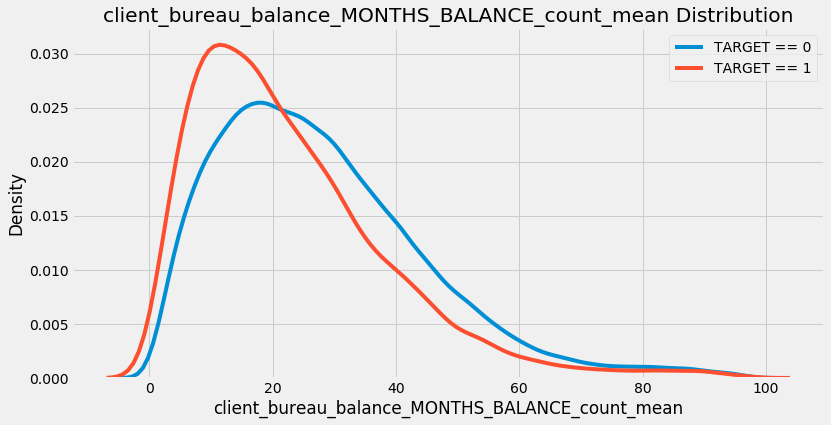

In [248]:
# 원문에는 client_bureau_balance_counts_mean 을 사용하고 있지만 해당 변수가 없어,
# 'client_bureau_balance_MONTHS_BALANCE_count_mean'으로 대체
kde_target(var_name='client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

(원문에는 client_bureau_balance_counts_mean 을 사용하고 있지만 해당 변수가 없어, client_bureau_balance_MONTHS_BALANCE_count_mean'으로 대체하였습니다.)

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid = 0.3636


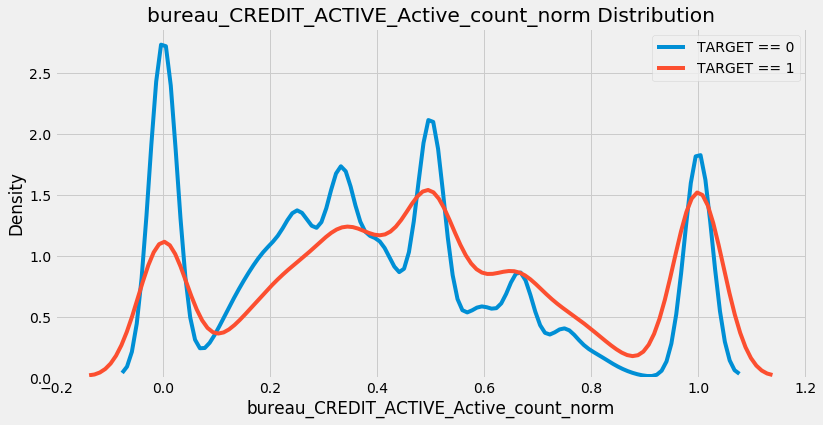

In [250]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

이 변수의 경우 모든 곳에서 불규칙합니다. 이 변수는 CREDIT_ACTIVE의 값이 'Active'인 것의 갯수를 전체 대출 갯수로 나눈 값입니다. 상관관계가 매우 약하기 때무에, 별도의 결론은 생각하지 않도록 하겠습니다.

### Collinear Variables
목표값(target)과 변수간의 상관계수만 계산하는 것이 아닌, 각 변수간 상관계수까지 계산할 수 있습니다. 이러한 방법은 제거해야 할 수도 있는 collinear 관계들을 가지는 변수들이 있는지 여부를 알려줍니다.

0.8 이상의 상관계수를 가지는 변수들을 찾아보도록하겠습니다.

In [255]:
# 임계치 설정
threshold = 0.8

# 상관계수가 높은 변수들을 저장하기 위한 빈 dictionary 생성
above_threshold_vars ={}

# 각각의 칼럼마다 임계치 이상의 변수들을 저장
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [268]:
# threshold보다 상관계수가 높은 값의 index값을 반환
corrs.index[corrs['client_bureau_balance_MONTHS_BALANCE_count_mean'] > 0.8]

Index(['client_bureau_balance_MONTHS_BALANCE_count_max', 'client_bureau_balance_MONTHS_BALANCE_count_mean'], dtype='object')

높은 상관관계를 가지는 변수들의 쌍에 대해서, 하나의 변수만을 제거해야 합니다. 아래의 코드는 각각의 쌍에서 한 개의 변수들만을 저장하는 set을 만드는 역할을 수행합니다.

In [272]:
# 제거할 column들 및 이미 검사된 column들의 목록을 저장위한 list 생성
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# columns 및 높은 상관관계를 가지는 columns를 따라 반복문 실행
### aboveabove_threshold_vars 변수는 딕셔터리형태로 생성되어있음.
for key, value in above_threshold_vars.items():                  #key와 value를 한꺼번에 for문을 반복하려면 items() 를 사용
    
    # 이미 검사된 column 저장
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else : 
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


이제 훈련용 데이터와 테스트 데이터에서 column들을 제거할 수 있습니다. 다만, column들을 제거한 데이터와 그렇지 않은 데이터로부터의 성능을 비교해보아야 합니다.<br>
(앞서 저장한 csv 파일을 활용할 수 있습니다.)

In [275]:
train_corrs_removed = train.drop(columns=cols_to_remove)
test_corrs_removed = test.drop(columns=cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [276]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

## 모델링 (Modeling)